# To do:

 - Both
     - Fix Injuries data
         - Find a better source for roster data (I found, work on the plyr_pos_xref notebook)
     - Signal Opp Injuries
 - Mins
 - PTS
     - Find more effective way to signal Defensive stats
 - Res_PTS
     - See notes in Res_PTS section

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import os
import json

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
    MDL_PATH = "../ML_models/dev"
else:
    RUN_LOCATION = "cloud"
    MDL_PATH = "../ML_models"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PTS"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-25
Target Stat: PTS


In [2]:
%run ./common_utils.ipynb

# ML Functions

In [3]:
def feature_importance(model, all_features):
    booster = model.get_booster()
    score = booster.get_score(importance_type="gain")

    df_importance = pd.DataFrame({
            "feature": all_features,
            "importance": [score.get(f, 0.0) for f in all_features]
        }).sort_values("importance", ascending=False).reset_index(drop=True)
    
    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    df_importance['importance'] = df_importance['importance'].map('{:.4f}'.format)
    if df_importance.shape[0] >= 50:
        with pd.option_context('display.max_rows', None):
            display(df_importance)
    else:
        display(df_importance)
    
    xgb.plot_importance(model)
    plt.show()

In [4]:
def compute_sample_weights(df, decay=0.99):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    max_date = df['Date'].max()
    df["days_old"] = (max_date - df['Date']).dt.days
    weights = decay ** df["days_old"]
    
    return weights.values

In [5]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg', 'game_spread_type'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_L5_avg',
            'MP_L10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [6]:
def hyperparam_tuning(DFS, pred_col, is_classification=False, n_iter=20, early_stopping_rounds=50, decay=1):
    """
    Hyperparameter tuning for XGBRegressor or XGBClassifier using native XGBoost API
    """
    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Season', 'Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Sample Weights (decay < 1)
    w_train = compute_sample_weights(train_df, decay=decay)
    w_val   = compute_sample_weights(val_df, decay=decay)
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train, enable_categorical=True)
    dval   = xgb.DMatrix(X_val, label=y_val, weight=w_val, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.005, 0.08),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(3, 10),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.5, 0.5),
        "gamma": uniform(0, 0.8),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 1)
    }

    # Generate n_iter random parameter sets
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k,v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_score = float('inf') if not is_classification else 0
    best_params = None
    best_bst = None

    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')

        # Set objective based on regression or classification
        if is_classification:
            params.update({
                "objective": "binary:logistic",
                "enable_categorical": True,
                "eval_metric": "logloss",
                "tree_method": "hist",
                "device": "cuda",
                "seed": 42
            })
        else:
            params.update({
                "objective": "reg:squarederror",
                "enable_categorical": True,
                "tree_method": "hist",
                "device": "cuda",
                "seed": 42
            })

        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        # Validation scoring
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        if is_classification:
            val_class = (val_preds > 0.5).astype(int)
            score = (val_class == y_val.values).mean()  # accuracy
            print(f"Validation Accuracy: {score:.4f}")
            if score > best_score:
                best_score = score
                best_params = params.copy()
                best_bst = bst
        else:
            mae = mean_absolute_error(y_val, val_preds)
            print(f"Validation MAE: {mae:.4f}")
            if mae < best_score:
                best_score = mae
                best_params = params.copy()
                best_bst = bst

    print("\nBest score:", best_score)
    print("Best parameters:", best_params)

    # Test predictions
    test_preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    if is_classification:
        test_class = (test_preds > 0.5).astype(int)
        acc = (test_class == y_test.values).mean()
        print("\nTest Accuracy:", acc)
    else:
        print("\nTest Metrics:")
        print("RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
        print("MAE:", mean_absolute_error(y_test, test_preds))
        print("R²:", r2_score(y_test, test_preds))

    return best_params

In [7]:
def refit_model(df, pred_col, params_file, min_train_days=0, rolling_window=None, decay=1):
    df = df.sort_values("Date")
    dates = df["Date"].unique()
    print(f'Rows: {df.shape[0]}, Dates: {len(dates)}, min_train_days: {min_train_days}')

    feature_cols = [c for c in df.columns if c not in ["Season", "Date", pred_col]]

    # Load hyperparameters
    with open(f"{MDL_PATH}/{params_file}.json", "r") as f:
        loaded_params = json.load(f)

    preds, actuals, dates_out, predictions = [], [], [], []
    total_iters = len(dates) - min_train_days

    for idx, i in enumerate(range(min_train_days, len(dates)), start=1):
        test_date = dates[i]
        test_season = df.loc[df["Date"] == test_date, "Season"].iloc[0]

        if rolling_window:
            train_start_idx = max(0, i - rolling_window)
        else:
            train_start_idx = 0

        train_dates = dates[train_start_idx:i]

        train_df = df[df["Date"].isin(train_dates)]
        test_df  = df[df["Date"] == test_date]

        if test_df.empty:
            continue

        X_train, y_train = train_df[feature_cols], train_df[pred_col]
        X_test, y_test   = test_df[feature_cols], test_df[pred_col]

        predictions.append(test_df)
        if pred_col == 'Bet':
            model = XGBClassifier(**loaded_params)
            model.fit(X_train, y_train)
            
            test_df['pred_prob'] = model.predict_proba(X_test)[:,1]
            test_df['pred_class'] = (test_df['pred_prob'] > 0.5).astype(int)
        else:
            model = XGBRegressor(**loaded_params)
            sample_weights = compute_sample_weights(train_df, decay=decay)
            model.fit(X_train, y_train, sample_weight=sample_weights)

            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates_out.extend([test_date] * len(y_pred))

        if idx % max(1, total_iters // 20) == 0:
            pct = 100 * idx / total_iters
            print(f"Progress: {pct:6.2f}% ({idx}/{total_iters})")
            
    results = pd.concat(predictions)
    if pred_col == 'Res_PTS':
        results['Actuals'] = actuals
        results['Predictions'] = preds
        mae = mean_absolute_error(actuals, preds)
        print("Walk-forward MAE:", mae)
        results["Correct_Direction"] = (np.sign(results["Predictions"]) == np.sign(results["Actuals"])).astype(int)
        for t in [0, 1, 2, 3]:
            subset = results[results["Predictions"].abs() >= t]
            acc = subset["Correct_Direction"].mean() if len(subset) > 0 else np.nan
            print(f"|Pred| >= {t}: accuracy = {acc:.3f}, n = {len(subset)}")
    elif pred_col == 'Bet':
        cm = confusion_matrix(results['Bet'], results['pred_class'])
        print("Confusion Matrix:\n", cm)
        report = classification_report(results['Bet'], results['pred_class'])
        print("Classification Report:\n", report)
        auc = roc_auc_score(results['Bet'], results['pred_prob'])
        print(f"ROC AUC: {auc:.3f}")

        high_confidence = results.copy()
        high_confidence['pred_prob'] = np.where(high_confidence.pred_prob > 0.5, 1 - high_confidence.pred_prob, high_confidence.pred_prob)
        high_confidence = high_confidence[high_confidence['pred_prob'] <= 0.3]
        if len(high_confidence) > 0:
            hit_rate = (high_confidence['pred_class'] == high_confidence['Bet']).mean()
            print(f"High-confidence hit rate (<= 0.3 & >= 0.7): {hit_rate:.2f}")

    else:
        results['Actuals'] = actuals
        results['Predictions'] = preds
        mae = mean_absolute_error(actuals, preds)
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        r2 = r2_score(actuals, preds)
        print(f"Walk-forward RMSE: {rmse:.3f}")
        print(f"Walk-forward MAE: {mae:.3f}")
        print(f"Walk-forward R²: {r2:.3f}")

    return model, results

### Create Base df

In [8]:
def load_df(file_name):
    df = pd.DataFrame()
    for i in [2021, 2022, 2023, 2024, 2025]:
        df_temp = pd.read_csv(f"../tables/{i}/{file_name}.csv")
        df_temp['Season'] = i
        df = pd.concat([df, df_temp])
        
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df.Date)
    if file_name == "season_gamelogs":
        df = df[~df[['Date', 'Team', 'Player']].duplicated(keep='last')]
    
    return df

In [9]:
# Load dfs
df = load_df('nba_schedule')
df2 = load_df('season_gamelogs')
# df3 = load_df('REPLACE ME')
df4 = load_df('injuries')
df5 = load_df('plyr_pos_xref')
df6 = load_df('daily_lineups')
gmlog_cols = ['game_id', 'Player', 'MP', 'PF', 'PTS', 'FG%']
df7 = load_df('h1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h1", "PF": "PF_h1", "PTS": "PTS_h1", "FG%": "FG%_h1"})
df8 = load_df('h2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h2", "PF": "PF_h2", "PTS": "PTS_h2", "FG%": "FG%_h2"})
df9 = load_df('q1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q1", "PF": "PF_q1", "PTS": "PTS_q1", "FG%": "FG%_q1"})
df10 = load_df('q2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q2", "PF": "PF_q2", "PTS": "PTS_q2", "FG%": "FG%_q2"})
df11 = load_df('q3_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q3", "PF": "PF_q3", "PTS": "PTS_q3", "FG%": "FG%_q3"})
df12 = load_df('q4_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q4", "PF": "PF_q4", "PTS": "PTS_q4", "FG%": "FG%_q4"})

df_mtch = df[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df = pd.concat([df_mtch, df_mtch2])
df = df.sort_values(["Team", "Date"])
df['team_game_num'] = df.groupby(["Team", "Season"]).cumcount() + 1
df['Spread'] = np.where(df.Team_type == 'Home', df.AwayPTS - df.HomePTS, df.HomePTS - df.AwayPTS)
df['Total'] = df.AwayPTS + df.HomePTS
df['is_Win'] = np.where(df.Spread > 0, 1, 0)
df['Szn_Wins'] = df.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.merge(df5, on=['Season', 'Team'])

df2 = df2.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"})
df2['PR'] = df2.PTS + df2.REB 
df2['PA'] = df2.PTS + df2.AST
df2['RA'] = df2.REB + df2.AST
df2['PRA'] = df2.PTS + df2.REB + df2.AST
df2['STL_BLK'] = df2.STL + df2.BLK
df = df.merge(df2.drop(['Pos', 'Opp', 'Team_type'], axis=1), on=['Season', 'Date', 'Team', 'Player'], how='left')

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

df6['role'] = 1
df = df.merge(df6.drop('Pos', axis=1), on=['Season', 'Date', 'Team', 'Player'], how='left')
df['role'] = df.role.fillna(2).astype(int)

# Add gmlog splits
df_gmlog_comb = df7.merge(df8, on=['game_id', 'Player'])
for df_loop in (df9, df10, df11, df12):
    df_gmlog_comb = df_gmlog_comb.merge(df_loop, on=['game_id', 'Player'])
df = df.merge(df_gmlog_comb, on=['game_id', 'Player'], how='left')

df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull()) & ~(df_lines.PTS_line.isnull())].drop(['Pos', 'Spread', 'Total'], axis=1)
df = df.merge(df_lines, on=['Date', 'Team', 'Player'], how='left')
df['Res_PTS'] = df.PTS - df.PTS_line

df = df.sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
df_td = df[df.Date == now]
df = df[(df.Active == 1) & (df.MP > 0)]
df_pred = df.copy()
df_pred = pd.concat([df_pred, df_td])
print('base df created', datetime.now())

base df created 2026-01-25 15:20:55.236152


### Feature Engineering Helper Functions

In [10]:
def create_df_missing(df, pred_col):

    df3 = load_df('season_gamelogs')
    df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
    df4 = load_df('injuries')
    
    # Fill missing games from injuries.csv
    team_games = df_pred[['Season', 'Team', 'Date']].drop_duplicates()
    players = df_pred[['Season','Player','Team']].drop_duplicates()
    fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
    fabricated['Season'] = fabricated['Season'] + 1
    players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
    expanded = team_games.merge(players, on=['Season', 'Team'], how='left')

    df5 = load_df('plyr_pos_xref')

    expanded = expanded.merge(df3[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
    expanded = expanded[(expanded.MP.isnull()) & (expanded.Date != now)].drop('MP', axis=1)
    expanded = pd.concat([expanded, df4[df4.Status == 'Out'][['Season', 'Team', 'Date', 'Player']]])
    df4 = df4.merge(expanded, on=['Season', 'Date', 'Team', 'Player'], how='right')

    # Grab outs from players season gamelogs
    df4 = df4.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='outer')
    df4['Status'] = np.where(((df4.Active == 1) | (df4.MP > 0)), 'Available', df4.Status)
    df4['Status'] = np.where(((df4.Active == 0) | (df4.MP == 0) | (df4.MP.isnull())), 'Out', df4.Status)
    df4['Status'] = np.where((df4.Status == 'Out') & (df4.MP > 0), 'Available', df4.Status)
    df4['Status'] = np.where((df4.Status != 'Out') & (df4.MP == 0), 'Out', df4.Status)
    df4 = df4[df4.Status == 'Out'][['Season', 'Date', 'Team', 'Player']].drop_duplicates()
    
    df_missing = df[['Season', 'Date', 'Team', 'Player', 'role', pred_col]].copy()
    df_missing[f'{pred_col}_L10'] = (
        df_missing.sort_values(['Player', 'Date']).groupby(['Player','Season'])[pred_col].shift(1)
                  .transform(lambda x: x.rolling(10, min_periods=10).mean())
    )
    df_missing['role_L10_mode'] = (
        df_missing.sort_values(['Player', 'Date'])
            .groupby(['Player', 'Season'])['role'].shift(1)
            .transform(lambda x: x.rolling(10, min_periods=10)
                            .apply(lambda y: np.bincount(y.astype(np.int8), minlength=4).argmax(), raw=True))
    )
    df_missing = pd.merge_asof(df4, df_missing[["Season", "Player", "Date", "role", "role_L10_mode", f"{pred_col}_L10"]], 
                      on="Date", by=["Player", "Season"], direction="backward", allow_exact_matches=True).dropna()   
    df_missing = df_missing.merge(df5, on=['Season', 'Team', 'Player'])
    
    # Filter out old injuries
    df_missing = df_missing.sort_values(["Season", "Team", "Player", "Date"])
    df_missing["team_game_num"] = (df_missing.groupby(["Season", "Team"])["Date"].rank(method="dense").astype(int))
    df_missing["game_break"] = (df_missing.groupby(["Season", "Team", "Player"])["team_game_num"].diff().ne(1))
    df_missing["streak_id"] = (df_missing.groupby(["Season", "Team", "Player"])["game_break"].cumsum())
    df_missing["consecutive_games"] = (df_missing.groupby(["Season", "Team", "Player", "streak_id"]).cumcount().add(1))
    df_missing["eligible_today"] = (df_missing["consecutive_games"] <= 10).astype(int)
    df_missing["role_for_count"] = np.where(df_missing["eligible_today"] == 1, df_missing["role_L10_mode"], np.nan)    
    df_missing[f'{pred_col}_L10'] = np.where(df_missing['role_for_count'] == 1, df_missing[f'{pred_col}_L10'], 0)

#     display(df_missing[(df_missing.Team == 'CLE') & (df_missing.Date == '2026-01-23')].tail(10))

    out_minutes = (
    df_missing
      .groupby(["Season", "Date", "Team"])
      .agg(
          tgt_available=(f"{pred_col}_L10", lambda x: x.sum()),
          starters_out=("role_for_count", lambda x: (x == 1).sum())
      )
      .reset_index()
    ).rename(columns={"tgt_available": f"team_{pred_col}_available"})

    return out_minutes

In [11]:
def filter_out_early_exits(df):
    for N in [3, 5, 10]:
        df[f'MP_L{N}_avg'] = (
            df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])['MP'].shift(1)
             .rolling(window=N, min_periods=N)
             .mean()
        )
    df['MP_base'] = df[['MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg']].mul([0.15, 0.25, 0.60]).sum(axis=1, skipna=True) / df[['MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg']].notna().mul([0.15, 0.25, 0.60]).sum(axis=1)    
    df['Early_Exit'] = ((df['MP_base'].notna()) & (df['MP_base'] > 0) &
                        (
                          ((df['MP'] - df['MP_base']) / df['MP_base'] <= -0.4) |  
                          ((df['MP_q4'] == 0) & (df['role'] == 1))
                        )).astype(int)    
    df = df[df.Early_Exit == 0]
    df = df.drop('Early_Exit', axis=1)
    
    return df

# Minutes Projection Model

In [12]:
def setup_df_mins(con, df):

    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'role',
             'MP', 'MP_q4', 'Spread', 'team_game_num', 'is_OT']]    
    cleanup_cols = []
    cold_features = []
    df = filter_out_early_exits(df)
    
    df['team_mins_pct'] = df['MP'] / (240 + (df.is_OT * 25))
    for col in ['MP', 'team_mins_pct']:
        for N in [3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                 .rolling(window=N, min_periods=N)
                 .mean()
            )
            df[f'is_cold_{col}_L{N}'] = (df.groupby(['Player', 'Season']).cumcount() < N).astype(int)
            cold_features.append(f'is_cold_{col}_L{N}')
            cleanup_cols.append(f'{col}_L{N}_avg')
    df['MP_base'] = df[['MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg']].mul([0.15, 0.25, 0.60]).sum(axis=1, skipna=True) / df[['MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg']].notna().mul([0.15, 0.25, 0.60]).sum(axis=1)
    df['MP_tm_pct_base'] = df[['team_mins_pct_L3_avg', 'team_mins_pct_L5_avg', 'team_mins_pct_L10_avg']].mul([0.15, 0.25, 0.60]).sum(axis=1, skipna=True) / df[['team_mins_pct_L3_avg', 'team_mins_pct_L5_avg', 'team_mins_pct_L10_avg']].notna().mul([0.15, 0.25, 0.60]).sum(axis=1)
    
    df['role'] = np.where((df.role == 2) & (df.MP_base < 13), 3, df.role)
    
    games_last_14_days = df.sort_values(['Player', 'Season', 'Date']).groupby(['Player', 'Season']).rolling('14D', on='Date', closed='left')['MP'].count().reset_index().rename(columns={"MP": "gms_L14_days"})
    games_last_14_days = games_last_14_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_14_days, on=['Player', 'Season', 'Date'])
    df['gms_L14_days'] = df.gms_L14_days.fillna(0).astype(int)    
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    df['games_since_return'] = (df.groupby(['Player', 'Team', 'Season']).apply(
                                    lambda g: (
                                        (g['team_game_num'].diff().sub(1).fillna(0).gt(0))
                                        .cumsum()
                                        .groupby((g['team_game_num'].diff().sub(1).fillna(0).gt(0)).cumsum()).cumcount()
                                    )
                                ).reset_index(level=[0,1,2], drop=True))

    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])['role'].shift(1)
              .transform(lambda x: x.rolling(N, min_periods=N)
                            .apply(lambda y: np.bincount(y.astype(np.int8), minlength=4).argmax(), raw=True))
        )
        df[f'is_cold_recent_role_L{N}'] = (df.groupby(['Player', 'Season']).cumcount() < N).astype(int)
        cold_features.append(f'is_cold_recent_role_L{N}')
        cleanup_cols.append(f"recent_role_L{N}")
    
#     df['game_spread_type'] = 0
#     df['game_spread_type'] = np.where(abs(df.Spread) < 13, 1, df.game_spread_type) 
#     df['game_spread_type'] = np.where((abs(df.Spread) >= 13) & (abs(df.Spread) <= 21), 2, df.game_spread_type) 
#     df['game_spread_type'] = np.where(abs(df.Spread) > 21, 3, df.game_spread_type) 
    
    df2 = create_df_missing(df, 'MP')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', 'team_MP_available']:
        df[col] = df[col].fillna(0).astype(int)
        
    df['starters_returning'] = ((df['missed_games'] > 0) & (df['role'] == 1)).astype(int)
    df['returning_MP'] = (
        (df['MP_L10_avg'] * df['starters_returning'])
        .groupby([df['Team'], df['Date']])
        .transform('sum')
    )
    
    df['starters_returning'] = df.sort_values(['Team', 'Date']).groupby(['Team', 'Date'])['starters_returning'].transform('sum')
    df['team_MP_available'] = df['team_MP_available'] - df['returning_MP']

    df['MP_Change'] = 0
    MP_Inc_conds = (
#                     ((df.role != 3) & (df.starters_out > 2)) | 
                    ((df.role == 1) & (df.recent_role_L1 > 1.0)).astype(int) + 
                    (df.team_MP_available >= 110).astype(int)
                   )
    
    MP_Dec_conds = (
                    ((df.role > 1) & ((df.recent_role_L1 == 1.0))).astype(int) + 
                    (df.team_MP_available < -23).astype(int)
                   ) * -1
    df['MP_Change'] = MP_Inc_conds + MP_Dec_conds

    df['scenario_mins'] = (
        df.sort_values(['Season','Team','role','Pos','Date'])
          .groupby(['Season','Team','role','Pos'])['MP'].shift(1)
          .expanding()
          .mean() 
          .reset_index(drop=True)
    )
    
    df['MP_trend'] = df['MP_L3_avg'] - df['MP_L10_avg']
    df['Expected_MP'] = (
        (0.8 * df['scenario_mins']) +
        (df['team_MP_available'] * df['MP_tm_pct_base']) + 
        (0.2 * df['MP_base']) + df['MP_trend']
    )
    
    df["is_cold_start"] = (df[cold_features].eq(1).any(axis=1).astype(int))
    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
    df = df.drop(['Team_type', 'team_game_num', 'is_OT', 'Spread', 'team_mins_pct', 'MP_tm_pct_base', 
                  'returning_MP', 'scenario_mins', 'MP_q4'] + cleanup_cols + cold_features, axis=1)    


    return df

,Season,Date,Team,Opp,Player,Pos,role,MP,MP_base,gms_L14_days,missed_games,games_since_return,team_MP_available,starters_out,starters_returning,MP_Change,MP_trend,Expected_MP,is_cold_start
0,2021,2021-10-19,BRK,MIL,Blake Griffin,C,1,22.98,NaN,0,0,0,0.0,0,0,0,NaN,NaN,1
1,2021,2021-10-19,BRK,MIL,Bruce Brown,SF,2,3.75,NaN,0,0,0,0.0,0,0,0,NaN,NaN,1
2,2021,2021-10-19,BRK,MIL,Cam Thomas,SG,2,3.75,NaN,0,0,0,0.0,0,0,0,NaN,NaN,1
3,2021,2021-10-19,BRK,MIL,DeAndre' Bembry,SF,2,3.75,NaN,0,0,0,0.0,0,0,0,NaN,NaN,1
4,2021,2021-10-19,BRK,MIL,James Harden,PG,1,30.63,NaN,0,0,0,0.0,0,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106150,2025,2026-01-24,WAS,CHO,Kyshawn George,SF,1,25.23,30.702900,6,0,7,51.0,2,0,0,3.332667,35.903732,0
106151,2025,2026-01-24,WAS,CHO,Malaki Branham,SG,2,7.52,17.180300,1,3,0,51.0,2,0,0,7.700333,34.693286,0
106152,2025,2026-01-24,WAS,CHO,Sharife Cooper,PG,3,9.47,2.733333,0,25,0,51.0,2,0,0,NaN,NaN,1
106153,2025,2026-01-24,WAS,CHO,Tre Johnson,SG,1,36.55,29.498800,6,0,21,51.0,2,0,0,3.198667,35.272981,0


Rows: 106155, Dates: 941, min_train_days: 910
Progress:   3.23% (1/31)
Progress:   6.45% (2/31)
Progress:   9.68% (3/31)
Progress:  12.90% (4/31)
Progress:  16.13% (5/31)
Progress:  19.35% (6/31)
Progress:  22.58% (7/31)
Progress:  25.81% (8/31)
Progress:  29.03% (9/31)
Progress:  32.26% (10/31)
Progress:  35.48% (11/31)
Progress:  38.71% (12/31)
Progress:  41.94% (13/31)
Progress:  45.16% (14/31)
Progress:  48.39% (15/31)
Progress:  51.61% (16/31)
Progress:  54.84% (17/31)
Progress:  58.06% (18/31)
Progress:  61.29% (19/31)
Progress:  64.52% (20/31)
Progress:  67.74% (21/31)
Progress:  70.97% (22/31)
Progress:  74.19% (23/31)
Progress:  77.42% (24/31)
Progress:  80.65% (25/31)
Progress:  83.87% (26/31)
Progress:  87.10% (27/31)
Progress:  90.32% (28/31)
Progress:  93.55% (29/31)
Progress:  96.77% (30/31)
Progress: 100.00% (31/31)
Walk-forward RMSE: 4.593
Walk-forward MAE: 3.615
Walk-forward R²: 0.730


,feature,importance,pct
0,role,63729.0664,0.596647
1,MP_base,16936.5703,0.755211
2,Player,6981.1875,0.820570
3,gms_L14_days,4437.0767,0.862111
4,MP_Change,2832.8557,0.888633
5,Expected_MP,2216.3860,0.909384
6,games_since_return,1822.2457,0.926444
7,is_cold_start,1419.4381,0.939733
8,missed_games,1297.4484,0.951880
9,team_MP_available,1164.0192,0.962778


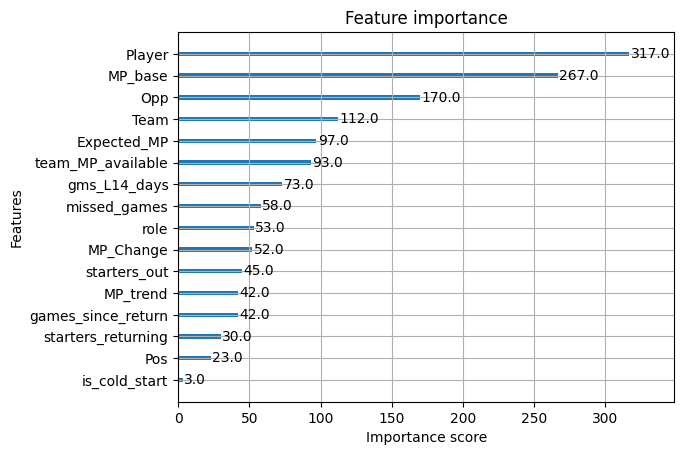

Saved Mins booster!


In [31]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

game_dates = (df_mins[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_end = game_dates.loc[int(0.70 * n_days), 'Date']
val_end   = game_dates.loc[int(0.80 * n_days), 'Date']

mins_train_df = df_mins[df_mins['Date'] <= train_end]
mins_val_df   = df_mins[(df_mins['Date'] > train_end) & (df_mins['Date'] <= val_end)]
mins_test_df  = df_mins[df_mins['Date'] > val_end]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# Prev r2/mae/rmse best: 0.7064/4.0508/5.1790 [1/24/2026]
# mins_params = hyperparam_tuning(mins_DFS, "MP", n_iter=25)
# with open(f"{MDL_PATH}/mins_params.json", "w") as f:
#     json.dump(mins_params, f)

# Prev r2/mae/rmse best: 0.729/3.615/4.599 [1/24/2026]
mins_model, mins_results = refit_model(df_mins, 'MP', 'mins_params', min_train_days=910, rolling_window=180)
# feature_importance(mins_model, df_mins.columns.tolist())

mins_model.get_booster().save_model(f"{MDL_PATH}/mins_model.json")
print('Saved Mins booster!')

In [ ]:
# analyze_df = mins_results.copy()
# analyze_df['Diff'] = analyze_df.Predictions - analyze_df.Actuals
# display(analyze_df[analyze_df.Date.isin(['2026-01-23'])].sort_values('Diff', ascending=False).head(10))

# plt.figure(figsize=(10,6))
# hist_col = 'Diff'
# plt.hist(analyze_df[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [ ]:
# df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
# df_lines['Date'] = pd.to_datetime(df_lines.Date)
# df_lines = df_lines[~(df_lines.Team.isnull())]

# df_lines["Team"] = team_encoder.transform(df_lines["Team"])
# df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
# df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
# df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
# df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
# df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
# df_prediction = df_pred.copy()

# # Predict Mins
# mins_booster = xgb.Booster()
# mins_booster.load_model("../ML_models/dev/mins_model.json")
# mins_model = XGBRegressor()
# mins_model._Booster = mins_booster

# df_prediction_mins = setup_df_mins(con, df_prediction)
# df_prediction_mins['MP_preds'] = mins_model.predict(df_prediction_mins.drop(['Season', 'Date', 'MP'], axis=1))
# df_prediction_mins = df_prediction_mins[df_prediction_mins.Date == now]

# df_prediction_mins['Team'] = team_encoder.inverse_transform(df_prediction_mins["Team"])
# df_prediction_mins['Opp'] = team_encoder.inverse_transform(df_prediction_mins["Opp"])
# df_prediction_mins['Player'] = player_encoder.inverse_transform(df_prediction_mins["Player"])

# if df_prediction_mins.shape[0] >= 50:
#     print(df_prediction_mins.shape[0], 'rows')
#     for tm in df_prediction_mins.Team.unique():
#         display(df_prediction_mins[df_prediction_mins.Team == tm])
# else:
#     display(df_prediction_mins)

# Stats Model

In [13]:
def setup_df_main(df, tgt_stat):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'MP_q4', 'team_game_num', 
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'Spread', 'Total']]
    cleanup_cols = []

    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
#     df['TeamPTS_type'] = 0
#     df['TeamPTS_type'] = np.where((df.TeamPTS < 110), 1, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS >= 110) & (df.TeamPTS <= 130), 2, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS > 130), 3, df.TeamPTS_type)

#     df[['pts_low', 'pts_mid', 'pts_high']] = pd.DataFrame({
#         'pts_low': ((110 - df.TeamPTS) / 20).clip(lower=0),
#         'pts_mid': (1 - abs(df.TeamPTS - 120) / 20).clip(lower=0),
#         'pts_high': ((df.TeamPTS - 130) / 20).clip(lower=0)
#     }, index=df.index)
#     w = df[['pts_low','pts_mid','pts_high']]
#     df[['pts_low','pts_mid','pts_high']] = w.div(w.sum(axis=1).replace(0,1), axis=0)
    
    
    # Create rolling + lag features
    df['eFG'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
    df['TS']  = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    df['TeamPTS_pct'] = df['PTS'] / df['TeamPTS']

    # Create rolling + lag features    
    for col in ['MP', tgt_stat, 'TeamPTS_pct', 'FGA']:
        for N in [1, 3, 5, 10]:
            if col == f'Def{tgt_stat}':
                df[f'Def{tgt_stat}_L{N}_avg'] = (
                    df[df.role <= 2]
                      .groupby(['Season', 'Date', 'Opp', 'Pos'])[tgt_stat]
                      .sum()
                      .groupby(['Opp', 'Pos', 'Season'])
                      .shift(1)
                      .rolling(window=N, min_periods=N)
                      .mean()
                      .reindex(df.set_index(['Season', 'Date', 'Opp', 'Pos']).index)
                      .values
                )
            else:
                df[f'{col}_L{N}_avg'] = (
                    df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                     .rolling(window=N, min_periods=N)
                     .mean()
                )
            cleanup_cols.append(f'{col}_L{N}_avg')
        df[f'{col}_base'] = ((df[f'{col}_L3_avg'] * 0.15) + (df[f'{col}_L5_avg'] * 0.25) + (df[f'{col}_L10_avg'] * 0.6))
    
    df['role'] = np.where((df.role == 2) & (df.MP_base < 13), 3, df.role)

    df2 = create_df_missing(df, tgt_stat)
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', f'team_{tgt_stat}_available']:
        df[col] = df[col].fillna(0)
    
    df['starters_returning'] = ((df['missed_games'] > 0) & (df['role'] == 1)).astype(int)
    df[f'returning_{tgt_stat}'] = (
        (df[f'{tgt_stat}_L10_avg'] * df['starters_returning'])
        .groupby([df['Team'], df['Date']])
        .transform('sum')
    )
    
    df['starters_returning'] = df.sort_values(['Team', 'Date']).groupby(['Team', 'Date'])['starters_returning'].transform('sum')
    df[f'team_{tgt_stat}_available'] = df[f'team_{tgt_stat}_available'] - df[f'returning_{tgt_stat}']
    
#     df['ProjPts'] = (df.TeamPTS * df.TeamPTS_pct_L10) + (df.team_PTS_available * df.TeamPTS_pct_L10) # TeamPTS is LEAKING
    df[f'scenario_{tgt_stat}'] = (
        df.sort_values(['Season','Team','role','Pos','Date'])
          .groupby(['Season','Team','role','Pos'])[tgt_stat].shift(1)
          .expanding()
          .mean() 
          .reset_index(drop=True)
    )
    
    df[f'Expected_{tgt_stat}'] = (
        (0.8 * df[f'scenario_{tgt_stat}']) +
        (df[f'team_{tgt_stat}_available'] * df['TeamPTS_pct_base']) + 
        (0.2 * df[f'{tgt_stat}_base'])
    )
    
    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
        
    df = df.drop(['team_game_num', 'missed_games', 'MP_q4', 'Spread', 'Total', 'role', 'MP_base', 'TeamPTS', 'TeamPTS_pct', 
                 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'eFG', 'TS',
                 f'returning_{tgt_stat}', 'starters_out', 'starters_returning', f'scenario_{tgt_stat}', f'team_{tgt_stat}_available'
                 ] + cleanup_cols, axis=1)

    return df

In [45]:
df_main = df.copy()
df_main = setup_df_main(df_main, tgt_stat)
display(df_main)

game_dates = (df_main[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_end = game_dates.loc[int(0.70 * n_days), 'Date']
val_end   = game_dates.loc[int(0.80 * n_days), 'Date']

main_train_df = df_main[df_main['Date'] <= train_end]
main_val_df   = df_main[(df_main['Date'] > train_end) & (df_main['Date'] <= val_end)]
main_test_df  = df_main[df_main['Date'] > val_end]
main_DFS = (main_train_df, main_val_df, main_test_df)

# Prev r2/mae/rmse best: 0.6706/3.7633/5.0858 [1/24/2026]
# stat_params = hyperparam_tuning(main_DFS, tgt_stat, n_iter=25, decay=0.99)
# with open(f"{MDL_PATH}/{tgt_stat}_params.json", "w") as f:
#     json.dump(stat_params, f)

# Prev r2/mae/rmse best: 0.695/3.628/4.840 [1/21/2026]
stat_model, stat_results = refit_model(df_main, tgt_stat, f'{tgt_stat}_params', min_train_days=910, decay=0.99)
# feature_importance(stat_model, df_main.columns.tolist())

stat_model.get_booster().save_model(f"{MDL_PATH}/{tgt_stat}_model.json")
print(f"Saved {tgt_stat} booster!")

,Season,Date,Team,Opp,Player,Pos,MP,PTS,PTS_base,TeamPTS_pct_base,FGA_base,Expected_PTS
0,2021,2021-10-19,BRK,MIL,Blake Griffin,C,22.98,6.0,NaN,NaN,NaN,NaN
1,2021,2021-10-19,BRK,MIL,Bruce Brown,SF,3.75,0.0,NaN,NaN,NaN,NaN
2,2021,2021-10-19,BRK,MIL,Cam Thomas,SG,3.75,2.0,NaN,NaN,NaN,NaN
3,2021,2021-10-19,BRK,MIL,DeAndre' Bembry,SF,3.75,0.0,NaN,NaN,NaN,NaN
4,2021,2021-10-19,BRK,MIL,James Harden,PG,30.63,20.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
126757,2025,2026-01-24,WAS,CHO,Kyshawn George,SF,25.23,11.0,18.44,0.169122,14.93,15.895473
126758,2025,2026-01-24,WAS,CHO,Malaki Branham,SG,7.52,3.0,5.08,0.045238,3.69,10.535130
126759,2025,2026-01-24,WAS,CHO,Sharife Cooper,PG,9.47,3.0,NaN,NaN,NaN,NaN
126760,2025,2026-01-24,WAS,CHO,Tre Johnson,SG,36.55,26.0,13.36,0.126919,11.91,13.963533


Rows: 126762, Dates: 941, min_train_days: 910
Progress:   3.23% (1/31)
Progress:   6.45% (2/31)
Progress:   9.68% (3/31)
Progress:  12.90% (4/31)
Progress:  16.13% (5/31)
Progress:  19.35% (6/31)
Progress:  22.58% (7/31)
Progress:  25.81% (8/31)
Progress:  29.03% (9/31)
Progress:  32.26% (10/31)
Progress:  35.48% (11/31)
Progress:  38.71% (12/31)
Progress:  41.94% (13/31)
Progress:  45.16% (14/31)
Progress:  48.39% (15/31)
Progress:  51.61% (16/31)
Progress:  54.84% (17/31)
Progress:  58.06% (18/31)
Progress:  61.29% (19/31)
Progress:  64.52% (20/31)
Progress:  67.74% (21/31)
Progress:  70.97% (22/31)
Progress:  74.19% (23/31)
Progress:  77.42% (24/31)
Progress:  80.65% (25/31)
Progress:  83.87% (26/31)
Progress:  87.10% (27/31)
Progress:  90.32% (28/31)
Progress:  93.55% (29/31)
Progress:  96.77% (30/31)
Progress: 100.00% (31/31)
Walk-forward RMSE: 4.893
Walk-forward MAE: 3.681
Walk-forward R²: 0.685
Saved PTS booster!


In [39]:
# analyze_df = stat_results.copy()
# analyze_df['Diff'] = analyze_df.Predictions - analyze_df.Actuals
# display(analyze_df[analyze_df.Date.isin(['2026-01-24'])].sort_values('Diff', ascending=True).head(10))

# plt.figure(figsize=(10,6))
# hist_col = 'Diff'
# plt.hist(analyze_df[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

# HT Stats

In [14]:
def setup_df_ht(df, tgt_stat):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'PTS_h1', 'team_game_num', 
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'Spread', 'Total']]
    cleanup_cols = []
    
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
#     df['TeamPTS_type'] = 0
#     df['TeamPTS_type'] = np.where((df.TeamPTS < 110), 1, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS >= 110) & (df.TeamPTS <= 130), 2, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS > 130), 3, df.TeamPTS_type)

#     df[['pts_low', 'pts_mid', 'pts_high']] = pd.DataFrame({
#         'pts_low': ((110 - df.TeamPTS) / 20).clip(lower=0),
#         'pts_mid': (1 - abs(df.TeamPTS - 120) / 20).clip(lower=0),
#         'pts_high': ((df.TeamPTS - 130) / 20).clip(lower=0)
#     }, index=df.index)
#     w = df[['pts_low','pts_mid','pts_high']]
#     df[['pts_low','pts_mid','pts_high']] = w.div(w.sum(axis=1).replace(0,1), axis=0)
    
    
    # Create rolling + lag features
    df['eFG'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
    df['TS']  = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    df['TeamPTS_pct'] = df['PTS'] / df['TeamPTS']

    # Create rolling + lag features    
    for col in ['MP', tgt_stat, 'TeamPTS_pct', 'FGA']:
        for N in [1, 3, 5, 10]:
            if col == f'Def{tgt_stat}':
                df[f'Def{tgt_stat}_L{N}_avg'] = (
                    df[df.role <= 2]
                      .groupby(['Season', 'Date', 'Opp', 'Pos'])[tgt_stat]
                      .sum()
                      .groupby(['Opp', 'Pos', 'Season'])
                      .shift(1)
                      .rolling(window=N, min_periods=N)
                      .mean()
                      .reindex(df.set_index(['Season', 'Date', 'Opp', 'Pos']).index)
                      .values
                )
            else:
                df[f'{col}_L{N}_avg'] = (
                    df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                     .rolling(window=N, min_periods=N)
                     .mean()
                )
            cleanup_cols.append(f'{col}_L{N}_avg')
        df[f'{col}_base'] = ((df[f'{col}_L3_avg'] * 0.15) + (df[f'{col}_L5_avg'] * 0.25) + (df[f'{col}_L10_avg'] * 0.6))
    
    df['role'] = np.where((df.role == 2) & (df.MP_base < 13), 3, df.role)

    df2 = create_df_missing(df, tgt_stat)
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', f'team_{tgt_stat}_available']:
        df[col] = df[col].fillna(0)
    
    df['starters_returning'] = ((df['missed_games'] > 0) & (df['role'] == 1)).astype(int)
    df[f'returning_{tgt_stat}'] = (
        (df[f'{tgt_stat}_L10_avg'] * df['starters_returning'])
        .groupby([df['Team'], df['Date']])
        .transform('sum')
    )
    
    df['starters_returning'] = df.sort_values(['Team', 'Date']).groupby(['Team', 'Date'])['starters_returning'].transform('sum')
    df[f'team_{tgt_stat}_available'] = df[f'team_{tgt_stat}_available'] - df[f'returning_{tgt_stat}']
    
#     df['ProjPts'] = (df.TeamPTS * df.TeamPTS_pct_L10) + (df.team_PTS_available * df.TeamPTS_pct_L10) # TeamPTS is LEAKING
    df[f'scenario_{tgt_stat}'] = (
        df.sort_values(['Season','Team','role','Pos','Date'])
          .groupby(['Season','Team','role','Pos'])[tgt_stat].shift(1)
          .expanding()
          .mean() 
          .reset_index(drop=True)
    )
    
    df[f'Expected_{tgt_stat}'] = (
        (0.8 * df[f'scenario_{tgt_stat}']) +
        (df[f'team_{tgt_stat}_available'] * df['TeamPTS_pct_base']) + 
        (0.2 * df[f'{tgt_stat}_base'])
    )
    
    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
        
    df = df.drop(['team_game_num', 'missed_games', 'Spread', 'Total', 'role', 'MP_base', 'TeamPTS', 'TeamPTS_pct', 
                 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'eFG', 'TS',
                 f'returning_{tgt_stat}', 'starters_out', 'starters_returning', f'scenario_{tgt_stat}', f'team_{tgt_stat}_available'
                 ] + cleanup_cols, axis=1)

    return df

In [90]:
# FEATURES IDEAS:
# Add MP_h1 to derive PPM_h1
# Get H1 team_pts_pct (need h1 pts)
# Get H2 rolling averages (h2, q3, q4)
# Add all shooting stats (fg%, ft%, tp%, attempts, makes, etc.)


df_ht = df.copy()
df_ht = setup_df_ht(df_ht, tgt_stat)
display(df_ht)

game_dates = (df_ht[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_end = game_dates.loc[int(0.70 * n_days), 'Date']
val_end   = game_dates.loc[int(0.80 * n_days), 'Date']

ht_train_df = df_ht[df_ht['Date'] <= train_end]
ht_val_df   = df_ht[(df_ht['Date'] > train_end) & (df_ht['Date'] <= val_end)]
ht_test_df  = df_ht[df_ht['Date'] > val_end]
ht_DFS = (ht_train_df, ht_val_df, ht_test_df)

# Prev r2/mae/rmse best: 0.8086/2.8569/3.8751 [1/25/2026]
# ht_params = hyperparam_tuning(ht_DFS, tgt_stat, n_iter=1, decay=0.99)
# with open(f"{MDL_PATH}/ht_{tgt_stat}_params.json", "w") as f:
#     json.dump(ht_params, f)

# Prev r2/mae/rmse best: 0.8086/2.8569/3.8751 [1/25/2026]
ht_model, ht_results = refit_model(df_ht, tgt_stat, f'ht_{tgt_stat}_params', min_train_days=910, decay=0.99)
# feature_importance(ht_model, df_ht.columns.tolist())

ht_model.get_booster().save_model(f"{MDL_PATH}/ht_{tgt_stat}_model.json")
print(f"Saved ht_{tgt_stat} booster!")

,Season,Date,Team,Opp,Player,Pos,MP,PTS_h1,PTS,PTS_base,TeamPTS_pct_base,FGA_base,Expected_PTS
0,2021,2021-10-19,BRK,MIL,Blake Griffin,C,22.98,6.0,6.0,NaN,NaN,NaN,NaN
1,2021,2021-10-19,BRK,MIL,Bruce Brown,SF,3.75,0.0,0.0,NaN,NaN,NaN,NaN
2,2021,2021-10-19,BRK,MIL,Cam Thomas,SG,3.75,0.0,2.0,NaN,NaN,NaN,NaN
3,2021,2021-10-19,BRK,MIL,DeAndre' Bembry,SF,3.75,0.0,0.0,NaN,NaN,NaN,NaN
4,2021,2021-10-19,BRK,MIL,James Harden,PG,30.63,15.0,20.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126757,2025,2026-01-24,WAS,CHO,Kyshawn George,SF,25.23,8.0,11.0,18.44,0.169122,14.93,15.895473
126758,2025,2026-01-24,WAS,CHO,Malaki Branham,SG,7.52,0.0,3.0,5.08,0.045238,3.69,10.535130
126759,2025,2026-01-24,WAS,CHO,Sharife Cooper,PG,9.47,0.0,3.0,NaN,NaN,NaN,NaN
126760,2025,2026-01-24,WAS,CHO,Tre Johnson,SG,36.55,18.0,26.0,13.36,0.126919,11.91,13.963533



Trial 1/1: {'n_estimators': 1390, 'learning_rate': np.float64(0.043801481965689386), 'max_depth': 3, 'min_child_weight': 6, 'subsample': np.float64(0.7657506783291828), 'colsample_bytree': np.float64(0.8880761816053027), 'gamma': np.float64(0.24776755391985905), 'reg_lambda': np.float64(4.712299532780405), 'reg_alpha': np.float64(0.7976750642992704)}
Validation MAE: 2.8050

Best score: 2.805012789074676
Best parameters: {'learning_rate': np.float64(0.043801481965689386), 'max_depth': 3, 'min_child_weight': 6, 'subsample': np.float64(0.7657506783291828), 'colsample_bytree': np.float64(0.8880761816053027), 'gamma': np.float64(0.24776755391985905), 'reg_lambda': np.float64(4.712299532780405), 'reg_alpha': np.float64(0.7976750642992704), 'objective': 'reg:squarederror', 'enable_categorical': True, 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 3.913614755983899
MAE: 2.8966297811884347
R²: 0.8048611678041651
Rows: 126762, Dates: 941, min_train_days: 910
Progress:

In [104]:
df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_prediction = df_pred.copy()

mins_booster = xgb.Booster()
mins_booster.load_model("../ML_models/dev/mins_model.json")
mins_model = XGBRegressor()
mins_model._Booster = mins_booster
df_prediction_mins = setup_df_mins(con, df_prediction)
df_prediction_mins['MP_preds'] = mins_model.predict(df_prediction_mins.drop(['Season', 'Date', 'MP'], axis=1))

df_ht = setup_df_ht(df_pred, tgt_stat)
df_ht = df_ht[df_ht.Date == now]
df_ht = df_ht.merge(df_prediction_mins[['Date', 'Team', 'Player', 'MP_preds']], on=['Date', 'Team', 'Player'])
df_ht['MP'] = df_ht['MP_preds']
df_ht = df_ht.drop('MP_preds', axis=1)
partition_save_df(df_ht, f"../tables/{YEAR}/ht_api_input.csv")

../tables/2025/ht_api_input.csv saved!


# Residual PTS

##### Try some sort of defensive rk L5 - d_rk today feature to measure difficulty increase/decrease
##### Create some short term Lx Average features for the target columns (Res_PTS/Bet)

In [15]:
def setup_df_res(df):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'MP_q4', 'team_game_num', 'Res_PTS', 'PTS_line',  
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 
             'Spread', 'Total']]
    
    # Create rolling + lag features
    df3 = load_df('season_gamelogs')
    df3 = con.execute("""SELECT Date, Team, CAST(ROUND(SUM(MP), 0) as INT) as Team_Mins, 
                         CAST(SUM(FGA) as INT) as Team_FGA, CAST(SUM(FTA) as INT) as Team_FTA, CAST(SUM(TOV) as INT) as Team_TOV 
                         FROM df3
                         GROUP BY Date, Team""").fetchdf()
    df = df.merge(df3, on=['Date', 'Team'], how='left')
    df['eFG'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
    df['TS']  = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    df['USG'] = (
        (df['FGA'] + 0.44*df['FTA'] + df['TOV']) * (df['Team_Mins'] / 5)
        / (df['MP'] * (df['Team_FGA'] + 0.44*df['Team_FTA'] + df['Team_TOV']))
    )

    LN_cols = []
    for col in ['MP', 'PTS', 'eFG', 'TS', 'USG']:
        for N in [3, 10]:
            if col != 'else':
                df[f'{col}_L{N}_avg'] = (
                    df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                     .rolling(window=N, min_periods=N)
                     .mean()
                )

                if col not in ['MP']:
                    LN_cols.append(f'{col}_L{N}_avg')
        df[f'{col}_trend'] = df[f'{col}_L3_avg'] - df[f'{col}_L10_avg']
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 13, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 13) & (abs(df.Spread) <= 18), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 18, 3, df.game_spread_type) 
    
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
#     df['TeamPTS_type'] = 0
#     df['TeamPTS_type'] = np.where((df.TeamPTS < 110), 1, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS >= 110) & (df.TeamPTS <= 130), 2, df.TeamPTS_type)
#     df['TeamPTS_type'] = np.where((df.TeamPTS > 130), 3, df.TeamPTS_type)

    df[['pts_low', 'pts_mid', 'pts_high']] = pd.DataFrame({
        'pts_low': ((110 - df.TeamPTS) / 20).clip(lower=0),
        'pts_mid': (1 - abs(df.TeamPTS - 120) / 20).clip(lower=0),
        'pts_high': ((df.TeamPTS - 130) / 20).clip(lower=0)
    }, index=df.index)
#     w = df[['pts_low','pts_mid','pts_high']]
#     df[['pts_low','pts_mid','pts_high']] = w.div(w.sum(axis=1).replace(0,1), axis=0)
        
    for col in ['TeamPTS']:
        for N in [3, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])[col].shift(1)
                  .rolling(window=N, min_periods=N)
                  .mean()
            )
            df[f'PTS_pct_L{N}'] = df[f'PTS_L{N}_avg'] / df[f'TeamPTS_L{N}_avg']
            df = df.drop(f'TeamPTS_L{N}_avg', axis=1)
        df['PTS_pct_trend'] = df['PTS_pct_L3'] - df['PTS_pct_L10']
        df = df.drop(['PTS_pct_L3', 'PTS_pct_L10'], axis=1)
    
    df2 = create_df_missing(df, 'PTS')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    for col in ['starters_out', 'team_PTS_available']:
        df[col] = df[col].fillna(0)
    df['starters_out_L1'] = (
        df.sort_values(['Player', 'Date']).groupby(['Player', 'Season'])['starters_out'].shift(1)
          .rolling(window=1, min_periods=1)
          .mean()
    )
    df['starters_returning'] = np.where(df['starters_out_L1'] > df['starters_out'], df['starters_out_L1'] - df['starters_out'], 0)

    df['Team'] = df['Team'].astype('category')
    df['Opp'] = df['Opp'].astype('category')
    df['Player'] = df['Player'].astype('category')
    df['Pos'] = df['Pos'].astype('category')
    df = df.drop(['team_game_num', 'Spread', 'Total', 'MP_q4', 'TeamPTS', 'Team_FGA', 'Team_FTA', 'Team_TOV', 
                 'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 'TOV', 'eFG', 'TS', 'USG', 
                  'Team_Mins', 'starters_out_L1'] + LN_cols, axis=1)
        
    return df

##### Regressor

In [16]:
df_res = df[(~df.PTS_line.isnull())].copy()
df_res = setup_df_res(df_res)
display(df_res)

game_dates = (df_res[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_end = game_dates.loc[int(0.70 * n_days), 'Date']
val_end   = game_dates.loc[int(0.80 * n_days), 'Date']

res_train_df = df_res[df_res['Date'] <= train_end]
res_val_df   = df_res[(df_res['Date'] > train_end) & (df_res['Date'] <= val_end)]
res_test_df  = df_res[df_res['Date'] > val_end]
res_DFS = (res_train_df, res_val_df, res_test_df)

# Prev r2/mae/rmse best: 0.2124/4.3069/5.6478 [1/24/2026]
# res_params = hyperparam_tuning(res_DFS, 'Res_PTS', n_iter=25)
# with open(f"{MDL_PATH}/Res_PTS_RG_params.json", "w") as f:
#     json.dump(res_params, f)

# Prev mae best: 4.1101 [1/18/2026]
res_model, res_results = refit_model(df_res, 'Res_PTS', 'Res_PTS_RG_params', min_train_days=50)
# feature_importance(res_model, df_res.columns.tolist())

res_model.get_booster().save_model(f"{MDL_PATH}/Res_PTS_RG_model.json")
print("Saved Res_PTS_RG booster!")

,Season,Date,Team,Opp,Player,Pos,role,MP,Res_PTS,PTS_line,MP_L3_avg,MP_L10_avg,MP_trend,PTS_trend,eFG_trend,TS_trend,USG_trend,game_spread_type,pts_low,pts_mid,pts_high,PTS_pct_trend,team_PTS_available,starters_out,starters_returning
0,2025,2025-11-20,ATL,SAS,Dyson Daniels,SG,1,30.68,-3.5,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.70,0.0,NaN,0.0,0.0,0.0
1,2025,2025-11-20,ATL,SAS,Jalen Johnson,SF,1,37.95,3.5,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.70,0.0,NaN,0.0,0.0,0.0
2,2025,2025-11-20,ATL,SAS,Kristaps Porzingis,C,1,29.05,-0.5,16.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.70,0.0,NaN,0.0,0.0,0.0
3,2025,2025-11-20,ATL,SAS,Nickeil Alexander-Walker,SG,1,33.65,20.5,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.70,0.0,NaN,0.0,0.0,0.0
4,2025,2025-11-20,ATL,SAS,Onyeka Okongwu,C,2,25.13,0.5,14.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0.70,0.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574,2025,2026-01-24,UTA,MIA,Svi Mykhailiuk,SF,1,17.23,1.5,6.5,21.020000,20.647,0.373000,-0.100000,-0.031667,0.012303,-0.033403,3,0.0,0.80,0.0,-0.001442,28.6,1.0,0.0
5575,2025,2026-01-24,WAS,CHO,Justin Champagnie,SF,2,32.12,3.5,11.5,23.483333,23.488,-0.004667,-1.566667,0.071234,0.087052,-0.029101,1,0.0,0.75,0.0,-0.012881,20.7,2.0,0.0
5576,2025,2026-01-24,WAS,CHO,Kyshawn George,SF,1,25.23,-6.5,17.5,33.216667,29.884,3.332667,5.933333,0.006602,0.038677,0.043711,1,0.0,0.75,0.0,0.061329,20.7,2.0,0.0
5577,2025,2026-01-24,WAS,CHO,Tre Johnson,SG,1,36.55,9.5,16.5,31.736667,29.091,2.645667,-1.533333,-0.099347,-0.105697,-0.023186,1,0.0,0.75,0.0,-0.011742,20.7,2.0,0.0


Rows: 5579, Dates: 64, min_train_days: 50
Progress:   7.14% (1/14)
Progress:  14.29% (2/14)
Progress:  21.43% (3/14)
Progress:  28.57% (4/14)
Progress:  35.71% (5/14)
Progress:  42.86% (6/14)
Progress:  50.00% (7/14)
Progress:  57.14% (8/14)
Progress:  64.29% (9/14)
Progress:  71.43% (10/14)
Progress:  78.57% (11/14)
Progress:  85.71% (12/14)
Progress:  92.86% (13/14)
Progress: 100.00% (14/14)
Walk-forward MAE: 4.203942871668152
|Pred| >= 0: accuracy = 0.656, n = 1432
|Pred| >= 1: accuracy = 0.701, n = 1022
|Pred| >= 2: accuracy = 0.737, n = 659
|Pred| >= 3: accuracy = 0.793, n = 396
Saved Res_PTS_RG booster!


##### Classifier

In [17]:
df_res = df[(~df.PTS_line.isnull())].copy()
df_res = setup_df_res(df_res)
df_res['Bet'] = (df_res['Res_PTS'] > 0).astype(int)  # 1 = over, 0 = under
df_res = df_res.drop('Res_PTS', axis=1)
# display(df_res)

game_dates = (df_res[['Date']].drop_duplicates().sort_values('Date').reset_index(drop=True))
n_days = len(game_dates)
train_cut = int(0.70 * n_days)
val_cut   = int(0.80 * n_days)
train_end = game_dates.loc[train_cut, 'Date']
val_end   = game_dates.loc[val_cut, 'Date']

res_train_df = df_res[df_res['Date'] <= train_end]
res_val_df   = df_res[(df_res['Date'] > train_end) & (df_res['Date'] <= val_end)]
res_test_df  = df_res[df_res['Date'] > val_end]
res_DFS = (res_train_df, res_val_df, res_test_df)

# Test Accuracy: 0.6672 [1/24/2026]
# res_params = hyperparam_tuning(res_DFS, 'Bet', is_classification=True, n_iter=25)
# with open(f"{MDL_PATH}/Res_PTS_CLF_params.json", "w") as f:
#     json.dump(res_params, f)

# Prev roc_auc best: 0.720 [1/18/2026]
res_model, res_results = refit_model(df_res, 'Bet', 'Res_PTS_RG_params', min_train_days=50)
# feature_importance(res_model, df_res.columns.tolist())

res_model.get_booster().save_model(f"{MDL_PATH}/Res_PTS_CLF_model.json")
print("Saved Res_PTS_CLF booster!")

Rows: 5492, Dates: 63, min_train_days: 50
Progress:   7.69% (1/13)
Progress:  15.38% (2/13)
Progress:  23.08% (3/13)
Progress:  30.77% (4/13)
Progress:  38.46% (5/13)
Progress:  46.15% (6/13)
Progress:  53.85% (7/13)
Progress:  61.54% (8/13)
Progress:  69.23% (9/13)
Progress:  76.92% (10/13)
Progress:  84.62% (11/13)
Progress:  92.31% (12/13)
Progress: 100.00% (13/13)
Confusion Matrix:
 [[446 245]
 [248 406]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.64       691
           1       0.62      0.62      0.62       654

    accuracy                           0.63      1345
   macro avg       0.63      0.63      0.63      1345
weighted avg       0.63      0.63      0.63      1345

ROC AUC: 0.693
High-confidence hit rate (<= 0.3 & >= 0.7): 0.78
Saved Res_PTS_CLF booster!


In [40]:
# df_yesterday = pd.read_csv(f'../tables/{YEAR}/gmday_preds_PTS.csv')
# df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
# df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
#                 .rename(columns={"MP": "MP_proj"})

# df_gms = pd.read_csv(f"../tables/{YEAR}/season_gamelogs.csv")
# df_gms['Date'] = pd.to_datetime(df_gms.Date)
# df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
# df_lines['Date'] = pd.to_datetime(df_lines.Date)
# df_lines = df_lines[~(df_lines.Team.isnull()) & ~(df_lines.PTS_line.isnull())].drop(['Pos', 'Spread', 'Total'], axis=1)
# df_gms = df_gms.merge(df_lines, on=['Date', 'Team', 'Player'])
# df_gms['Res_PTS'] = df_gms.PTS - df_gms.PTS_line

# df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'PTS', 'Res_PTS', 'MP']], on=['Date', 'Team', 'Player'])
# df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'MP', 'MP_proj', 'PTS_line', 'PTS_proj', 'PTS', 'Res_PTS_proj', 'Res_PTS', 'pred_prob', 'pred_class']][df_yesterday.MP > 0]

# # Mins
# df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
# df_yesterday['InTgtRange'] = np.where(df_yesterday['Diff'] <= 5, 1, 0)
# print("\nYesterday's Results:")
# print("Total Accuracy (Minutes-in-range):", (df_yesterday.InTgtRange == 1).mean())
# print((df_yesterday.InTgtRange == 1).sum(), '/', df_yesterday.shape[0])
# df_yesterday = df_yesterday.drop(['Diff', 'InTgtRange'], axis=1)

# # Raw PTS
# df_yesterday['Diff'] = abs(df_yesterday['PTS'] - df_yesterday['PTS_proj'])
# df_yesterday['InTgtRange'] = np.where(df_yesterday['Diff'] <= 3, 1, 0)
# df_yesterday['Act_Res'] = np.where((df_yesterday.PTS > df_yesterday.PTS_line), 1, 0)
# df_yesterday['Pred_Res'] = np.where((df_yesterday.PTS_proj > df_yesterday.PTS_line), 1, 0)
# df_yesterday['PHit1'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
# print("Total Accuracy (Raw PTS):", (df_yesterday.PHit1 == 1).mean())
# print((df_yesterday.PHit1 == 1).sum(), "/", df_yesterday.shape[0])
# print("Total Accuracy (Raw PTS-in-range):", (df_yesterday.InTgtRange == 1).mean())
# df_yesterday = df_yesterday.drop(['Diff', 'InTgtRange', 'Act_Res', 'Pred_Res'], axis=1)

# # Res PTS (Regression)
# df_yesterday['Act_Res'] = np.where(df_yesterday['Res_PTS'] > 0, 'O', 'U')
# df_yesterday['Pred_Res'] = np.where(df_yesterday['Res_PTS_proj'] > 0, 'O', 'U')
# df_yesterday['PHit2'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
# print("Total Accuracy (ResPTS Regression):", (df_yesterday.PHit2 == 1).mean())
# print((df_yesterday.PHit2 == 1).sum(), "/", df_yesterday.shape[0])
# df_yesterday = df_yesterday.drop(['Act_Res', 'Pred_Res'], axis=1)

# # Res PTS (Classifier)
# df_yesterday['Act_Res'] = np.where(df_yesterday['Res_PTS'] > 0, 1, 0)
# df_yesterday['PHit3'] = np.where(df_yesterday['Act_Res'] == df_yesterday['pred_class'], 1, 0)
# df_yesterday['pred_class'] = np.where(df_yesterday['pred_class'] == 1, 'O', 'U')
# print("Total Accuracy (ResPTS Classification):", (df_yesterday.PHit3 == 1).mean())
# print((df_yesterday.PHit3 == 1).sum(), "/", df_yesterday.shape[0])
# df_yesterday = df_yesterday.drop(['Act_Res'], axis=1)

# df_yesterday['Majority'] = np.where(((df_yesterday.PTS_proj > df_yesterday.PTS_line).astype(int) + (df_yesterday['Res_PTS_proj'] > 0).astype(int) + (df_yesterday['pred_class'] == 1).astype(int)) >= 2, 1, 0)
# df_yesterday['MajorityHit'] = np.where((df_yesterday.Majority == 1) & (df_yesterday.PTS > df_yesterday.PTS_line), 1, 0)
# df_yesterday['MajorityHit'] = np.where((df_yesterday.Majority == 0) & (df_yesterday.PTS < df_yesterday.PTS_line), 1, df_yesterday.MajorityHit)
# print("Total Accuracy (MajorityHit):", (df_yesterday.MajorityHit == 1).mean())

# df_yesterday['AllAgree'] = '-'
# df_yesterday['AllAgree'] = np.where((df_yesterday.PHit1 == 1) & (df_yesterday.PHit2 == 1) & (df_yesterday.PHit3 == 1), 1, df_yesterday['AllAgree'])
# df_yesterday['AllAgree'] = np.where((df_yesterday.PHit1 == 0) & (df_yesterday.PHit2 == 0) & (df_yesterday.PHit3 == 0), 0, df_yesterday['AllAgree'])
# print("Total Accuracy (AllAgree):", ((df_yesterday.AllAgree == 1).sum() / ((df_yesterday.AllAgree == 0).sum() + (df_yesterday.AllAgree == 1).sum())))

# df_yesterday = df_yesterday.drop(['Majority', 'MajorityHit', 'AllAgree'], axis=1).sort_values('PTS_line', ascending=False)

# # if df_yesterday.shape[0] >= 50:
# #     for tm in df_yesterday.Team.unique():
# #         display(df_yesterday[(df_yesterday.Team == tm)]) #  & (df_yesterday.PHit == 1)
# # else:
# #     display(df_yesterday)

# Today's predictions

In [15]:
df_lines = pd.read_csv(f"../tables/{YEAR}/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_prediction = df_pred.copy()

# Predict Mins
mins_booster = xgb.Booster()
mins_booster.load_model("../ML_models/dev/mins_model.json")
mins_model = XGBRegressor()
mins_model._Booster = mins_booster

df_prediction_mins = setup_df_mins(con, df_prediction)
df_prediction_mins['MP_preds'] = mins_model.predict(df_prediction_mins.drop(['Season', 'Date', 'MP'], axis=1))

# Predict Stat
stat_booster = xgb.Booster()
stat_booster.load_model(f"../ML_models/dev/{tgt_stat}_model.json")
stat_model = XGBRegressor()
stat_model._Booster = stat_booster
res_booster_RG = xgb.Booster()
res_booster_RG.load_model("../ML_models/dev/Res_PTS_RG_model.json")
res_model_RG = XGBRegressor()
res_model_RG._Booster = res_booster_RG
res_model_CLF = XGBClassifier()
res_model_CLF.load_model("../ML_models/dev/Res_PTS_CLF_model.json")

df_prediction = setup_df_main(df_prediction, 'PTS')
df_prediction = df_prediction.merge(df_prediction_mins[['Date', 'Team', 'Player', 'MP_preds']], on=['Date', 'Team', 'Player'], how='left')
df_prediction['MP'] = df_prediction.MP.fillna(df_prediction.MP_preds)
feature_cols = [col for col in df_prediction.columns if col not in ['Season', 'Date', 'MP_preds', 'PTS']]
df_prediction = df_prediction[df_prediction.Date == now][feature_cols]
df_prediction["PTS_proj"] = stat_model.predict(df_prediction)

df_prediction2 = df_pred[(~df_pred.PTS_line.isnull())].copy()
df_prediction2 = setup_df_res(df_prediction2)
df_prediction2 = df_prediction2.merge(df_prediction_mins[['Date', 'Team', 'Player', 'MP_preds']], on=['Date', 'Team', 'Player'], how='left')
df_prediction2['Player'] = df_prediction2['Player'].astype('category')
df_prediction2['MP'] = df_prediction2.MP.fillna(df_prediction2.MP_preds)
feature_cols = [col for col in df_prediction2.columns if col not in ['Season', 'Date', 'MP_preds', 'Res_PTS']]
df_prediction2 = df_prediction2[df_prediction2.Date == now][feature_cols]
df_prediction2["Res_PTS_proj"] = res_model_RG.predict(df_prediction2)

df_prediction2['pred_prob'] = res_model_CLF.predict_proba(df_prediction2.drop('Res_PTS_proj', axis=1))[:,1]
df_prediction2['pred_class'] = (df_prediction2['pred_prob'] > 0.5).astype(int)

# Setup Today's Picks
df_lines = df_lines[df_lines.Date == now][['Team', 'Player', 'PTS_line']]
df_prediction = df_prediction.merge(df_lines, on=['Team', 'Player'])
df_prediction = df_prediction.merge(df_prediction2[['Team', 'Player', 'Res_PTS_proj', 'pred_prob', 'pred_class']], on=['Team', 'Player'])

tds_picks = df_prediction[~(df_prediction['PTS_line'].isnull())]\
            [['Team', 'Player', 'MP', 'PTS_line', 'PTS_proj', 'Res_PTS_proj', 'pred_prob', 'pred_class']]

tds_picks['O/U'] = '-'
tds_picks['O/U'] = np.where(((tds_picks.pred_class == 1) & (tds_picks.PTS_proj > tds_picks.PTS_line) & (tds_picks.Res_PTS_proj > 0)), 'O', tds_picks['O/U'])
tds_picks['O/U'] = np.where(((tds_picks.pred_class == 0) & (tds_picks.PTS_proj < tds_picks.PTS_line) & (tds_picks.Res_PTS_proj < 0)), 'U', tds_picks['O/U'])

tds_picks = tds_picks.sort_values(['O/U', 'Team', 'Player'], ascending=[False, False, False])
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)
tds_picks.insert(0, 'Date', pd.to_datetime(now))
partition_save_df(tds_picks, f"../tables/{YEAR}/gmday_preds_PTS.csv")

102 rows


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
96,UTA,Lauri Markkanen,26.583038,26.5,21.261848,-4.950861,0.295433,0,U
91,UTA,Brice Sensabaugh,23.432976,15.5,12.871613,-0.386240,0.359340,0,U
97,UTA,Svi Mykhailiuk,20.826462,6.5,7.552686,0.442660,0.601695,1,O
95,UTA,Kyle Filipowski,28.262657,10.5,11.661707,1.159000,0.569149,1,O
92,UTA,Cody Williams,26.407541,7.5,10.744872,2.198689,0.571276,1,O
94,UTA,Keyonte George,35.974522,26.5,25.499172,2.670352,0.549691,1,-
93,UTA,Jusuf Nurkic,24.591263,14.5,12.586752,-1.032357,0.502081,1,-
90,UTA,Ace Bailey,29.931885,13.5,14.478393,-0.216880,0.484958,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
82,ORL,Paolo Banchero,36.432297,23.5,21.508966,-0.580544,0.425204,0,U
81,ORL,Moritz Wagner,16.266972,7.5,6.829162,-0.792365,0.305018,0,U
80,ORL,Jalen Suggs,26.759066,12.5,15.398234,0.845551,0.530606,1,O
78,ORL,Desmond Bane,34.706501,18.5,18.543482,1.605174,0.556320,1,O
83,ORL,Wendell Carter Jr.,30.494619,10.5,12.602302,1.904142,0.492136,0,-
79,ORL,Goga Bitadze,16.749683,4.5,6.712016,1.218693,0.485531,0,-
77,ORL,Anthony Black,27.543165,15.5,14.641392,3.079295,0.779365,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
61,MIA,Norman Powell,31.770662,23.5,22.521095,-0.009844,0.333565,0,U
62,MIA,Pelle Larsson,28.432869,11.5,11.659116,1.020655,0.544392,1,O
60,MIA,Nikola Jovic,21.630852,7.5,8.788869,0.504837,0.517677,1,O
58,MIA,Jaime Jaquez Jr.,28.544550,14.5,15.546708,0.149857,0.611132,1,O
63,MIA,Simone Fontecchio,21.802652,9.5,10.818262,-0.993899,0.446043,0,-
59,MIA,Kasparas Jakucionis,19.098291,7.5,6.377888,0.366329,0.442404,0,-
57,MIA,Davion Mitchell,30.236238,8.5,9.536863,1.049191,0.470443,0,-
56,MIA,Bam Adebayo,33.427265,20.5,19.253176,0.720302,0.486148,0,-
55,MIA,Andrew Wiggins,32.229805,16.5,15.892962,0.704071,0.571709,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
54,LAL,Rui Hachimura,23.897833,10.5,8.997827,-0.814264,0.421738,0,U
53,LAL,Marcus Smart,30.041588,8.5,10.750069,1.179112,0.559747,1,O
51,LAL,LeBron James,34.719788,22.5,22.647846,0.246672,0.665928,1,O
48,LAL,Jake LaRavia,32.466354,7.5,10.319761,2.385819,0.631912,1,O
46,LAL,Deandre Ayton,30.127779,12.5,12.858854,1.518864,0.627746,1,O
52,LAL,Luka Doncic,36.936180,34.5,29.288925,0.162431,0.593353,1,-
50,LAL,Jaxson Hayes,16.757109,5.5,6.796225,0.225120,0.327436,0,-
49,LAL,Jarred Vanderbilt,19.139849,4.5,5.135554,0.191381,0.323406,0,-
47,LAL,Gabe Vincent,17.698877,4.5,4.972157,-1.424813,0.141439,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
41,GSW,Brandin Podziemski,25.432707,13.5,11.302764,-1.529447,0.432505,0,U
43,GSW,Draymond Green,28.748127,8.5,9.380214,1.468069,0.535288,1,O
45,GSW,Stephen Curry,33.448006,29.5,25.505970,2.220460,0.678052,1,-
44,GSW,Moses Moody,26.901752,11.5,11.132741,1.535399,0.602259,1,-
42,GSW,De'Anthony Melton,21.583241,12.5,11.566342,0.527808,0.532565,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
31,CLE,Sam Merrill,22.272911,12.5,11.687180,-0.338912,0.432284,0,U
27,CLE,Donovan Mitchell,35.377670,28.5,27.082750,-0.524720,0.440857,0,U
26,CLE,Dean Wade,27.441809,6.5,8.077568,2.211479,0.546926,1,O
30,CLE,Jaylon Tyson,30.545332,16.5,15.088944,1.194798,0.620669,1,-
29,CLE,Jarrett Allen,31.072960,13.5,13.717990,-0.087120,0.226474,0,-
28,CLE,Evan Mobley,34.418777,18.5,17.501303,0.348698,0.500877,1,-
25,CLE,De'Andre Hunter,23.804007,10.5,11.480094,0.171609,0.479766,0,-
24,CLE,Craig Porter Jr.,21.197529,6.5,6.560196,0.081752,0.467380,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
21,CHO,Miles Bridges,32.377144,17.5,15.555693,-0.315074,0.434664,0,U
23,CHO,Ryan Kalkbrenner,20.997967,7.5,8.559025,0.437101,0.660474,1,O
22,CHO,Moussa Diabate,28.968697,7.5,8.267022,0.983339,0.675335,1,O
18,CHO,Collin Sexton,20.245819,12.5,12.683172,1.513767,0.741186,1,O
20,CHO,LaMelo Ball,27.743120,19.5,18.993671,2.320640,0.559472,1,-
19,CHO,Kon Knueppel,31.460091,18.5,16.671967,2.978424,0.645055,1,-
17,CHO,Brandon Miller,32.292435,20.5,20.019365,0.606264,0.470109,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
6,BOS,Payton Pritchard,32.931347,16.5,16.435602,-1.035905,0.462511,0,U
2,BOS,Jaylen Brown,35.598484,30.5,27.954847,-2.557363,0.441654,0,U
1,BOS,Derrick White,34.834446,17.5,16.396906,-0.226877,0.351249,0,U
7,BOS,Sam Hauser,29.101934,11.5,13.679636,3.745479,0.530232,1,O
5,BOS,Neemias Queta,26.150118,6.5,10.872120,2.916164,0.595672,1,O
4,BOS,Luka Garza,18.032051,7.5,8.718190,0.133715,0.583408,1,O
0,BOS,Anfernee Simons,25.807837,13.5,14.996614,2.220080,0.565816,1,O
3,BOS,Jordan Walsh,16.646843,3.5,5.011510,0.244721,0.369923,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
89,PHI,VJ Edgecombe,37.313129,13.5,15.684787,3.234652,0.636215,1,O
88,PHI,Tyrese Maxey,40.071316,28.5,28.892900,5.186477,0.588238,1,O
87,PHI,Quentin Grimes,27.592209,8.5,11.537722,1.119302,0.503424,1,O
84,PHI,Joel Embiid,34.757004,25.5,25.629124,2.112997,0.762819,1,O
86,PHI,Paul George,32.802864,14.5,15.093306,1.549612,0.485489,0,-
85,PHI,Kelly Oubre Jr.,29.150242,13.5,12.954255,1.258773,0.554377,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
76,NYK,OG Anunoby,35.719936,15.5,16.040142,0.310239,0.680408,1,O
74,NYK,Miles McBride,25.623573,10.5,12.947052,3.847000,0.648098,1,O
73,NYK,Mikal Bridges,36.345833,14.5,15.739663,1.394589,0.500109,1,O
71,NYK,Josh Hart,35.070831,11.5,13.681679,1.439870,0.574676,1,O
75,NYK,Mitchell Robinson,19.143723,5.5,5.804307,0.435409,0.430563,0,-
72,NYK,Karl-Anthony Towns,33.286236,19.5,17.956873,-0.149034,0.506760,1,-
70,NYK,Jalen Brunson,36.433357,26.5,23.752382,0.442631,0.564468,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
68,MIN,Naz Reid,27.072578,14.5,14.661274,3.473274,0.651365,1,O
66,MIN,Jaden McDaniels,34.029545,14.5,15.040203,1.615152,0.646758,1,O
65,MIN,Donte DiVincenzo,33.121265,12.5,13.235135,0.933703,0.577949,1,O
69,MIN,Rudy Gobert,32.343987,10.5,10.002377,1.356531,0.426199,0,-
67,MIN,Julius Randle,34.550957,22.5,22.403851,1.617293,0.679046,1,-
64,MIN,Anthony Edwards,37.775719,29.5,27.534241,0.870981,0.689950,1,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
37,DAL,Klay Thompson,21.990839,11.5,11.537678,0.052393,0.626579,1,O
32,DAL,Brandon Williams,28.169199,13.5,15.126826,2.735716,0.817784,1,O
40,DAL,P.J. Washington,31.960686,13.5,13.001760,1.743528,0.641237,1,-
39,DAL,Naji Marshall,28.555326,17.5,15.364027,3.195791,0.777143,1,-
38,DAL,Max Christie,31.579123,14.5,14.249679,2.805155,0.626338,1,-
36,DAL,Dwight Powell,20.900391,3.5,5.885374,0.331379,0.473756,0,-
35,DAL,Daniel Gafford,22.452492,7.5,8.720497,-1.290902,0.522492,1,-
34,DAL,Cooper Flagg,33.339710,19.5,18.021894,1.562230,0.595991,1,-
33,DAL,Caleb Martin,18.201443,3.5,5.043992,-0.024853,0.401100,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
14,CHI,Matas Buzelis,29.312420,13.5,16.142990,2.158730,0.531792,1,O
12,CHI,Josh Giddey,31.695293,13.5,16.864325,1.131729,0.515034,1,O
10,CHI,Isaac Okoro,26.717470,8.5,9.283509,2.503175,0.670237,1,O
8,CHI,Ayo Dosunmu,25.737541,12.5,14.066781,2.464859,0.746825,1,O
16,CHI,Patrick Williams,18.302561,5.5,6.803979,0.074067,0.433152,0,-
15,CHI,Nikola Vucevic,31.399012,16.5,16.026234,2.012236,0.501348,1,-
13,CHI,Kevin Huerter,24.927513,8.5,10.735602,0.628698,0.499193,0,-
11,CHI,Jalen Smith,23.264854,11.5,10.918476,1.323622,0.458777,0,-
9,CHI,Coby White,31.771030,17.5,18.378433,-1.162635,0.489285,0,-


,Team,Player,MP,PTS_line,PTS_proj,Res_PTS_proj,pred_prob,pred_class,O/U
101,WAS,Will Riley,25.151096,11.5,9.610357,0.805878,0.515328,1,-
100,WAS,Tre Johnson,30.119692,16.5,14.226295,1.234923,0.677440,1,-
99,WAS,Kyshawn George,31.779032,17.5,15.944405,0.360946,0.544415,1,-
98,WAS,Justin Champagnie,23.366501,11.5,9.393100,0.596394,0.410754,0,-


../tables/2025/gmday_preds_PTS.csv saved!


In [174]:
# tds_picks['PTS_proj_mag'] = tds_picks.PTS_proj - tds_picks.PTS_line
# print('O:', tds_picks[tds_picks.PTS_proj_mag > 0].shape[0] / tds_picks.shape[0])
# print('U:',tds_picks[tds_picks.PTS_proj_mag < 0].shape[0] / tds_picks.shape[0])

# plt.figure(figsize=(10,6))
# hist_col = 'PTS_proj_mag'
# plt.hist(tds_picks[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()
# tds_picks = tds_picks.drop('PTS_proj_mag', axis=1)

In [61]:
# print('O:',tds_picks[tds_picks.Res_PTS_proj > 0].shape[0] / tds_picks.shape[0])
# print('U:',tds_picks[tds_picks.Res_PTS_proj < 0].shape[0] / tds_picks.shape[0])

# plt.figure(figsize=(10,6))
# hist_col = 'Res_PTS_proj'
# plt.hist(tds_picks[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [62]:
# print('O:', tds_picks[tds_picks.pred_class == 1].shape[0] / tds_picks.shape[0])
# print('U:', tds_picks[tds_picks.pred_class == 0].shape[0] / tds_picks.shape[0])

# plt.figure(figsize=(10,6))
# hist_col = 'pred_prob'
# plt.hist(tds_picks[hist_col], bins=30, color='skyblue', edgecolor='black')
# plt.title(f'Histogram of {hist_col}')
# plt.xlabel(hist_col)
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

# Misc.

In [26]:
# # Historical Percentages
# df_yesterday = pd.read_csv(f'../tables/{YEAR}/gmday_preds_{tgt_stat}.csv')
# df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
# df_yesterday = df_yesterday.rename(columns={"MP": "MP_proj"})

# df_gms = pd.read_csv(f"../tables/{YEAR}/season_gamelogs.csv")
# df_gms['Date'] = pd.to_datetime(df_gms.Date)

# df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
# df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'MP', 'MP_proj', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

# df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
# df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
# df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
# df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
# df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
# df_yesterday['Diff3'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
# df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff3'] <= 5, 1, 0)

# for day in df_gms.Date.unique():
#     df_temp = df_yesterday[df_yesterday.Date == day]
#     if df_temp.shape[0] > 0:
#         print(f"{day.date()} Total PTS Accuracy:", f"{(df_temp.ParlayHit == 1).sum()}/{df_temp.shape[0]}", ((df_temp.ParlayHit == 1).sum() / df_temp.shape[0]))
#         print(f"{day.date()} Total MP Accuracy:", f"{(df_temp.InRMSE_Range == 1).sum()}/{df_temp.shape[0]}", ((df_temp.InRMSE_Range == 1).sum() / df_temp.shape[0]), "\n")

In [28]:
# df_mins = df.copy()
# df_mins = setup_df_mins(con, df_mins)

# train_summary = df_mins.drop(['Season', 'Date', 'MP'], axis=1).describe().T
# gameday_summary = df_prediction_mins[df_prediction_mins.Date == now].drop(['Season', 'Date', 'MP'], axis=1).describe().T
# display(train_summary[['mean','std']])
# display(gameday_summary[['mean','std']])

In [29]:
# df_main = df.copy()
# df_main = setup_df_main(df_main, tgt_stat)

# train_summary = df_main.drop(['Season', 'Team', 'Opp', 'Player', 'Pos', 'Date', 'PTS'], axis=1).describe().T
# gameday_summary = df_prediction[(~df_prediction.PTS_line.isnull())].drop(['Pos', 'PTS_proj', 'Res_PTS_proj', 'pred_prob', 'pred_class', 'PTS_line'], axis=1).describe().T
# display(train_summary[['mean','std']])
# display(gameday_summary[['mean','std']])

In [30]:
# df_res = df[(~df.PTS_line.isnull())].copy()
# df_res = setup_df_res(df_res)

# train_summary = df_res.drop(['Date', 'Res_PTS'], axis=1).describe().T
# gameday_summary = df_prediction2[(~df_prediction2.PTS_line.isnull())].describe().T
# display(train_summary[['mean','std']])
# display(gameday_summary[['mean','std']])

In [31]:
# for col in mins_train_df.drop(['Season', 'Date', 'MP'], axis=1).columns:
#     if col not in ['Team', 'Player', 'Opp', 'Pos']:
#         PartialDependenceDisplay.from_estimator(
#             mins_model,
#             mins_train_df.drop(['Season', 'Date', 'MP'], axis=1),
#             features=[col],
#             grid_resolution=25
#         )
        
# ##################
# features = [('role')]
# PartialDependenceDisplay.from_estimator(
#     mins_model,
#     mins_train_df.drop(['Season', 'Date', 'MP'], axis=1),
#     features=features,
#     grid_resolution=25
# )